In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from matplotlib.patches import Rectangle

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

sys.path.append("../")
from data import gestalt

%load_ext autoreload
%autoreload 2

In [2]:
dataset = gestalt.Gestalt(passes=["images", "bounding_boxes", "masks"])
batch = dataset.__getitem__(100)

34526 # training scenes, 3832 # test scenes


In [4]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model


In [5]:
model = get_model_instance_segmentation(2)

# MaskRCNN Pre-Trained

First, let's see how the model runs out of the box. Then, we'll fine-tune it on our dataset and observe how it's improved.

/om2/user/yyf/miniconda/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([2, 1, 128, 128])


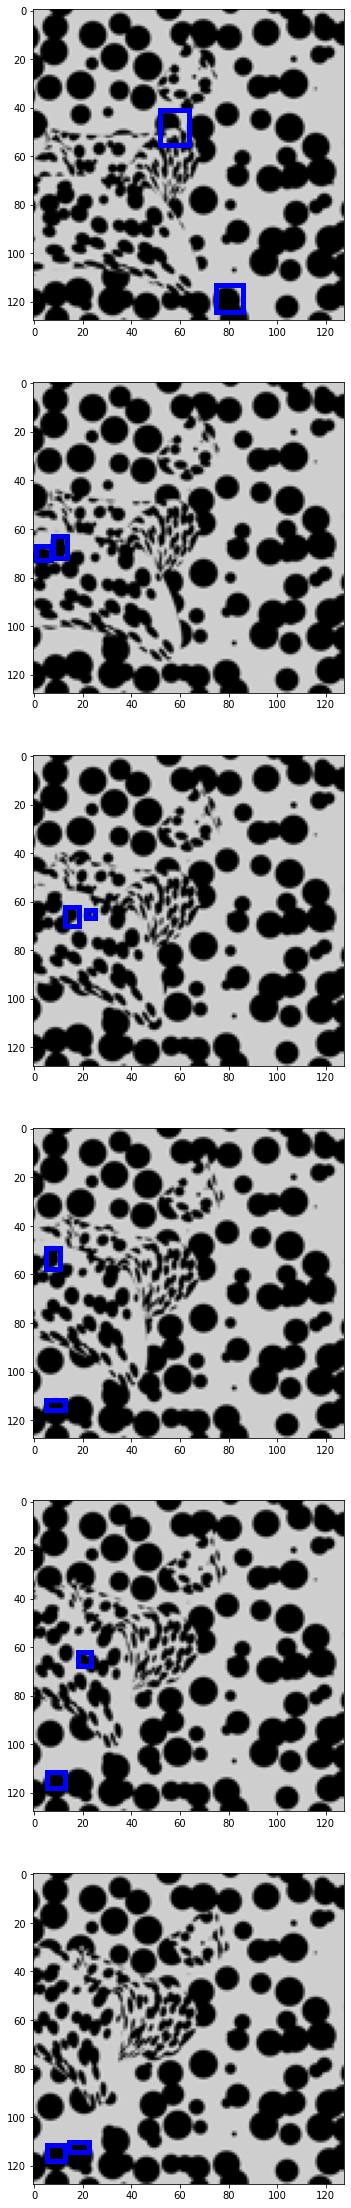

In [6]:
outputs = []
model.to("cuda")
model.eval()
images = batch[0].to("cuda")
boxes = batch[1]["boxes"]
areas = batch[1]["area"]
output = model(images)

output_masks = []
for i in range(len(output)):
    output[i]["masks"] = output[i]["masks"][output[i]["scores"].topk(2)[1]]
    
for i in range(len(output)):
    output[i]["boxes"] = output[i]["boxes"][output[i]["scores"].topk(2)[1]]
    
print(output[i]["masks"].shape)
plot(images, [o["boxes"] for o in output], [o["masks"] for o in output])

In [161]:
from engine import train_one_epoch, evaluate
import utils


def main():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has two classes only - background and person
    num_classes = 2
    # use our dataset and defined transformations
    dataset = gestalt.Gestalt(frames_per_scene=1, sub_level=["superquadric_3"],
                              passes=["images", "masks", "bounding_boxes"])

    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset, indices[-50:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=4, shuffle=True, num_workers=2,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=2,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    #model = get_model_instance_segmentation(num_classes)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 10

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        #train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

    print("That's it!")

In [165]:
main()

16524 # training scenes, 1834 # test scenes


ValueError: expected sequence of length 1 at dim 1 (got 0)

In [194]:
test_data = gestalt.Gestalt(root_dir="/om2/user/yyf/CommonFate/scenes",
    top_level=["test_voronoi", "test_noise", "test_wave"], passes=["masks", "images", "normals", "bounding_boxes"], 
                           frames_per_scene=6, resolution=(256, 256))


30 # training scenes, 0 # test scenes


In [193]:
def plot(images, pred_boxes, masks, normals):
    fig, ax = plt.subplots(len(images), 3, figsize=(20, 40))
    for i in range(images.shape[0]):

        ax[i, 1].imshow(images[i].detach().cpu().numpy().transpose(1, 2, 0), cmap="gray")
        ax[i, 2].imshow(images[i].detach().cpu().numpy().transpose(1, 2, 0), cmap="gray")

        for mask in masks[i]:
            ax[i, 2].imshow(mask, cmap='jet', alpha=0.5)
            
        for box in pred_boxes[i]:
            box = box.detach().cpu().numpy()
            xy = (box[0], box[1])
            h, w = box[2] - box[0], box[3] - box[1]
            rect = Rectangle(xy, h, w, linewidth=5, edgecolor="r", facecolor="none")
            ax[i, 2].add_patch(rect)
            
        ax[i, 0].imshow(normals[i])
    
    ax[0, 0].set_title("Surface Normals")
    ax[0, 1].set_title("Input Image")
    ax[0, 2].set_title("MaskRCNN Bounding Boxes + Mask")
    
    plt.show()

In [216]:
model.eval()

mIOU = []

for i in range(len(test_data)):
    batch = test_data.__getitem__(i)
    images = batch[0].to("cuda")
    masks = batch[1]["masks"]
    bbox = batch[1]["bounding_boxes"].to("cuda").type(torch.uint8)
    
    output = model(images)

    scene_dir = batch[1]["scene_dir"]
    k = int(scene_dir.split("/")[-2].split("_")[-1])
    
    for i in range(len(output)):
        try:
            output[i]["masks"] = output[i]["masks"][output[i]["scores"].topk(k)[1]].detach()
        except:
            output[i]["masks"] = output[i]["masks"][output[i]["scores"].topk(1)[1]].detach()
        #output[i]["masks"] = np.ma.masked_where(output[i]["masks"] == 0, output[i]["masks"])

    for i in range(len(output)):
        try:
            output[i]["boxes"] = output[i]["boxes"][output[i]["scores"].topk(k)[1]]
        except:
            output[i]["boxes"] = output[i]["boxes"][output[i]["scores"].topk(1)[1]]
            
    l = len(output)
    pred_masks = torch.cat([output[i]["masks"] for i in range(l)], dim=0).to("cuda").type(torch.uint8)
    pred_boxes = torch.cat([output[i]["boxes"] for i in range(l)], dim=0).to("cuda").type(torch.uint8)
    
    print(pred_boxes.shape, bbox.shape)
    m_iou = (pred_boxes | bbox) / (pred_boxes & bbox)
    mIOU.append(m_iou)
    
#plot(images, pred_boxes=[o["boxes"] for o in output], masks=[o["masks"] for o in output], normals=normals)

torch.Size([12, 4]) torch.Size([6, 2, 4])


RuntimeError: The size of tensor a (12) must match the size of tensor b (2) at non-singleton dimension 1

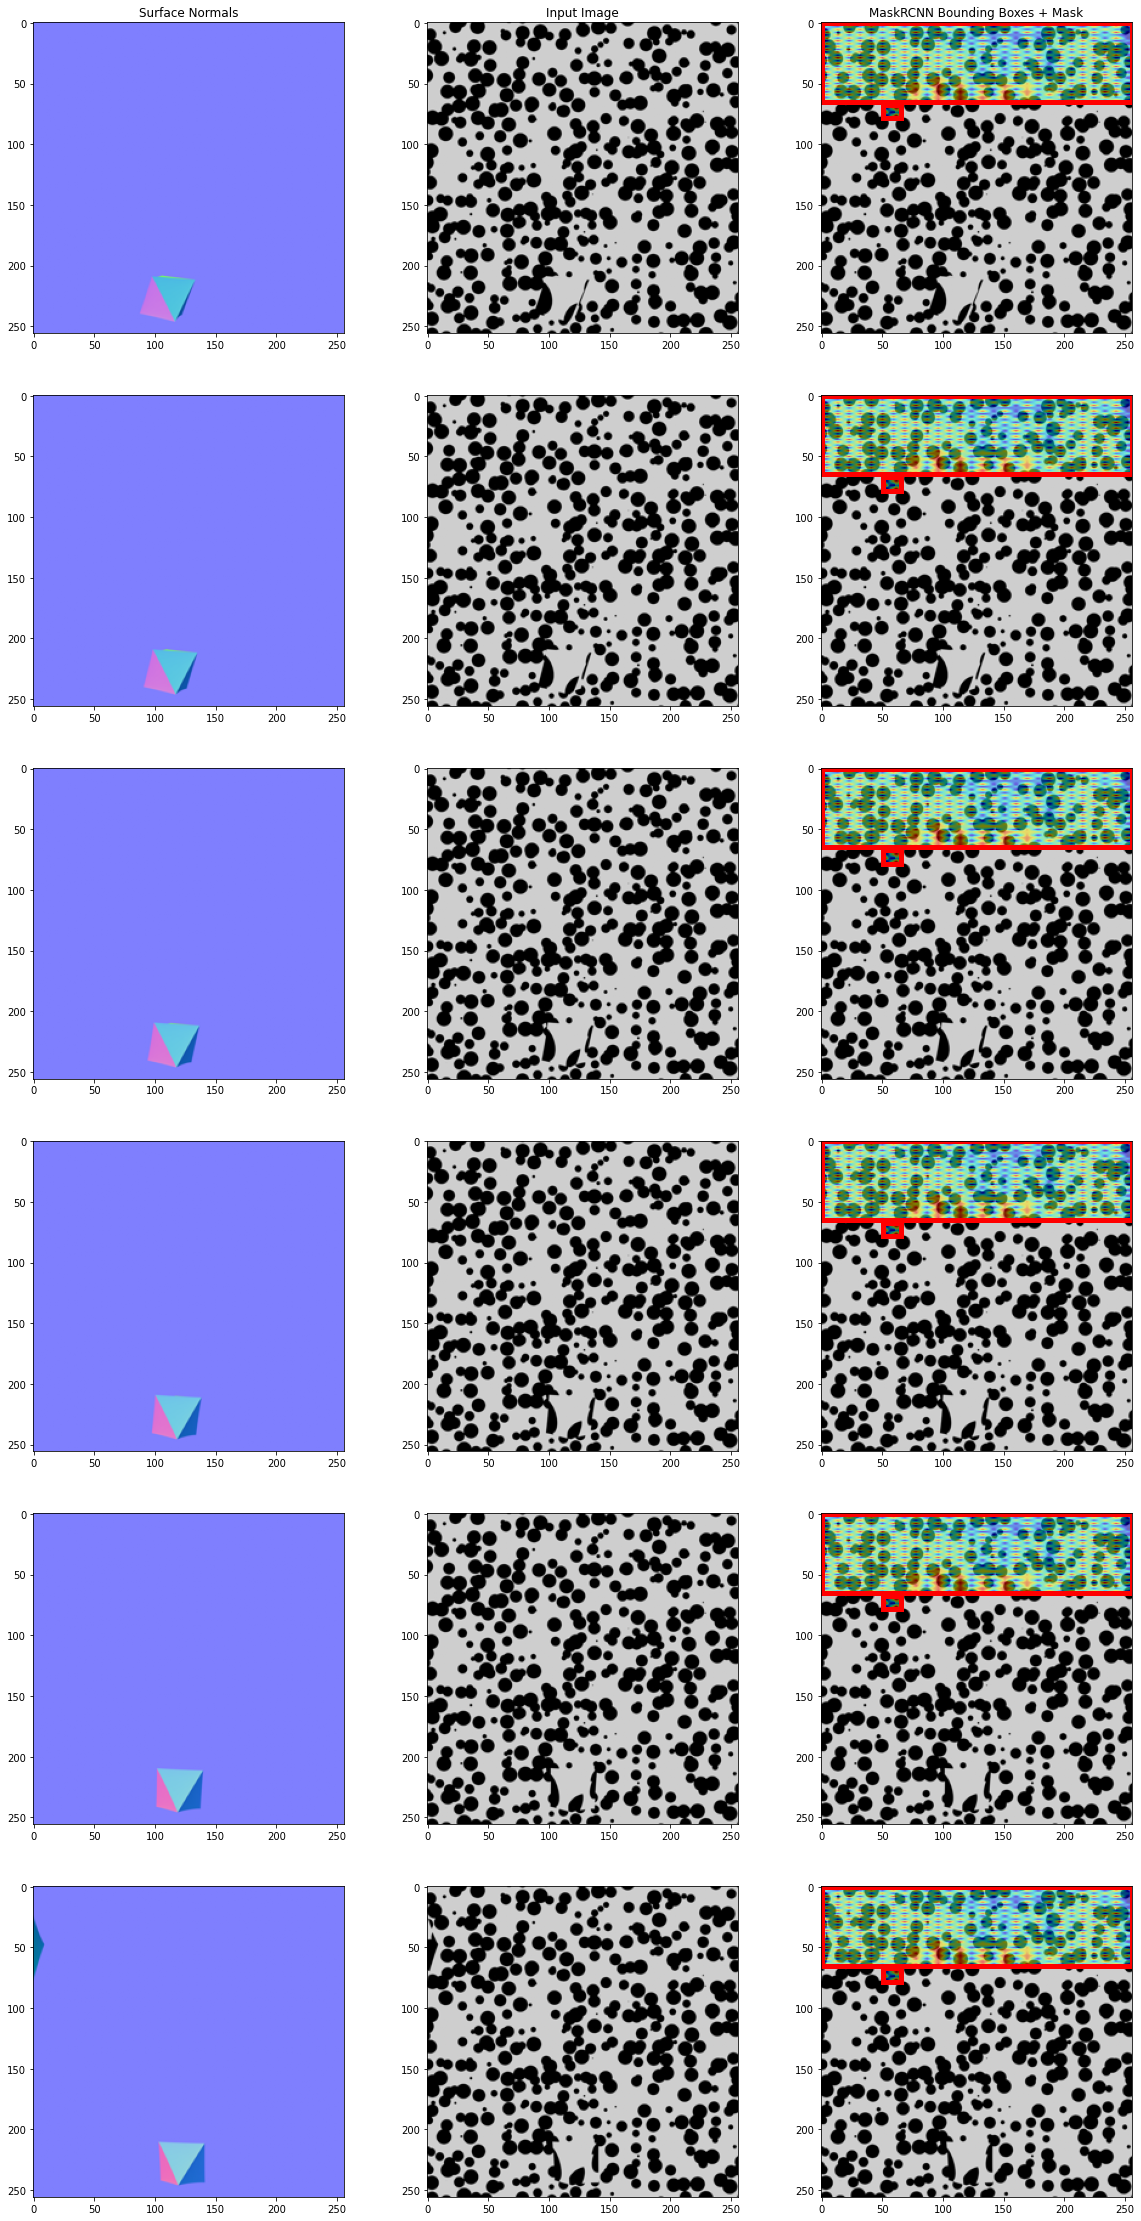

In [181]:
images, targets = test_data.__getitem__(np.random.randint(0, len(test_data)))
normals = targets["normals"].detach().cpu().numpy().transpose((0, 2, 3, 1))
base_model = get_model_instance_segmentation(2).to("cuda")
base_model.eval()
base_output = base_model(images.to("cuda"))


for i in range(len(base_output)):
    base_output[i]["masks"] = base_output[i]["masks"][output[i]["scores"].topk(k)[1]].detach().cpu().numpy().transpose(
    0, 2, 3, 1)
    base_output[i]["masks"] = np.ma.masked_where(base_output[i]["masks"] == 0, base_output[i]["masks"])
    
for i in range(len(output)):
    base_output[i]["boxes"] = base_output[i]["boxes"][base_output[i]["scores"].topk(k)[1]]
    
plot(images, pred_boxes=[o["boxes"] for o in base_output], masks=[o["masks"] for o in base_output], normals=normals)   